# Analysis

Eventually, the talks were classified manually. (A rule of thumb for classifying corpora of texts is that there ought to be at least 2,000 entries, and we have only 1,272 talk abstracts.) But before that decision, a number of classification methods were attempted. These helped reveal categories (It's how  "best practice" got its name) and brought to light things that were outside of our awareness, like (blush) the existence of Plone.

We didn't classify the keynotes because they had no abstract, didn't do tutorials because many were the same every year, and didn't classify posters because adding them would make it seem like there were a ton more talks all of a sudden on the year they started.

## Step one

Just look at the word counts and bigrams -- see what's there.

In [1]:
import altair as alt
import get
from collections import Counter, OrderedDict

In [2]:
stem = False
all_words = {}
everything = Counter()
for talk in get.talks():
    conference = '{}-{}'.format(talk.conference.name, talk.conference.year)
    if conference not in all_words:
        all_words[conference] = Counter()
    tokens = set(get.bigrams(talk.title.lower(), stem=stem))
    tokens.update(set(get.unigrams(talk.title.lower(), stem=stem)))
    abstract = '' if talk.abstract is None else talk.abstract.lower()
    tokens.update(set(get.bigrams(abstract, stem=stem)))
    everything.update(tokens)
    all_words[conference].update(tokens)

#### What's there?

Web, data, open source and programming; (no surprise, but too general), best practices, applications, and Django are in the top 20 phrases.

In [3]:
print(everything.most_common(20))

[('open source', 108), ('using', 72), ('web', 60), ("'s", 58), ('data', 55), ('standard library', 47), ('web applications', 47), ('testing', 46), ('applications', 40), ('web application', 37), ('building', 37), ("'ll cover", 37), ("'ll show", 36), ("'ll discuss", 35), ('django', 33), ('lessons learned', 31), ('best practices', 31), ('introduction', 30), ('web framework', 30), ('programming', 29)]


#### Conference by conference?

Twisted early on, Django in the middle, and machine learning at the end. But see how even the most frequent terms appear in 10 or fewer talks -- organizers did a good job of picking a diverse mix of topics. Diversity in talks is fun, but presents a challenge: if every talk is different, it will be hard to classify them into categories.

In [4]:
for conf in sorted(all_words):
    data = all_words[conf]
    print(conf)
    print(data.most_common(12))
    print()

pycon-us-2003
[('twisted', 5), ('framework', 4), ('slides available', 4), ('web', 4), ('zope', 3), ('networking framework', 3), ('twisted networking', 3), ('large', 3), ('open source', 3), ('package', 3), ('using', 3), ('twisted framework', 3)]

pycon-us-2004
[("'' ``", 9), ("`` ''", 8), ("'' ''", 6), ('using', 6), ('open source', 5), ('implemented using', 5), ('yet another', 4), ('software foundation', 4), ('web applications', 4), ('standard library', 4), ('web server', 4), ('make sure', 4)]

pycon-us-2005
[('open source', 11), ('using', 6), ('user interface', 6), ('standard library', 5), ('application framework', 5), ('wide variety', 4), ('software', 4), ('web application', 4), ('system', 4), ('applications', 4), ("'s standard", 3), ('application', 3)]

pycon-us-2006
[('open source', 7), ('using', 5), ('application development', 4), ('web', 4), ('zope', 4), ('application', 3), ('data entry', 3), ('applications written', 3), ('programming language', 3), ('system', 3), ('case study', 3

## Step two

Try simple clustering. So, keep each talk separate this time. Terms that occur only once can't help with clustering, so don't include them. Check for an idea of what's there, take a reasonable middle range of the terms, convert them to an array, and then cluster them.

In [5]:
for n in range(1, 11):
    print('{} terms in at least {} talks'.format(
        len([w for w, ct in everything.most_common() if ct >= n]), n))

106318 terms in at least 1 talks
7765 terms in at least 2 talks
2557 terms in at least 3 talks
1262 terms in at least 4 talks
799 terms in at least 5 talks
544 terms in at least 6 talks
408 terms in at least 7 talks
306 terms in at least 8 talks
242 terms in at least 9 talks
198 terms in at least 10 talks


In [6]:
# Keep only terms that occur frequently (but not too frequently)
lower_bound, upper_bound = 4, 50
middle_terms = set(w for w, ct in everything.most_common()
                   if lower_bound <= ct and ct <= upper_bound)

def keep_middle(terms):
    return (t for t in terms if t in middle_terms)

In [7]:
stem = False
talks = OrderedDict()  # map talk title to Counter of terms

for talk in get.talks():
    tokens = set(keep_middle(get.bigrams(talk.title.lower(), stem=stem)))
    tokens.update(keep_middle(get.unigrams(talk.title.lower(), stem=stem)))
    abstract = '' if talk.abstract is None else talk.abstract.lower()
    tokens.update(keep_middle(get.bigrams(abstract, stem=stem)))
    talks[talk.title] = dict.fromkeys(tokens, 1)

In [8]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
dataset = vec.fit_transform(talks.values()).toarray()

#### K-means clustering

First try different numbers of clusters. Then pick a number, cluster, and see how well distributed the groups are.

In [9]:
# Kmeans
from sklearn.cluster import KMeans

performance = []
for n in range(2, 42, 2):
    cluster_maker = KMeans(n_clusters=n)
    cluster_maker.fit(dataset)
    performance.append({'clusters':n, 'inertia':cluster_maker.inertia_})

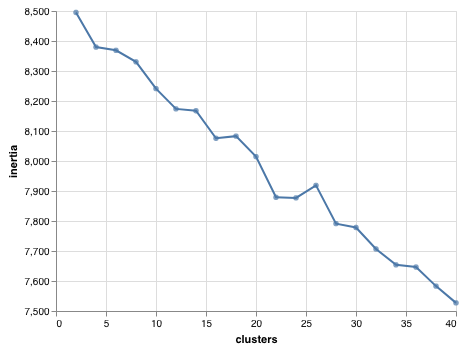

In [10]:
# Just see if there's an obvious knee in the plot
data = alt.Data(values=performance)

lines = alt.Chart(data).mark_line().encode(
    alt.X('clusters:Q', scale=alt.Scale(zero=False)),
    alt.Y('inertia:Q', scale=alt.Scale(zero=False))
)

points = alt.Chart(data).mark_circle().encode(
    alt.X('clusters:Q', scale=alt.Scale(zero=False)),
    alt.Y('inertia:Q', scale=alt.Scale(zero=False))
)

lines + points

#### Twelve
Go with 12 clusters. There's not really a knee, but how can we deal with like 40 clusters?

In [11]:
n = 12
cluster_maker = KMeans(n_clusters=n)
cluster_maker.fit(dataset)
Counter(cluster_maker.labels_)

Counter({11: 1164,
         6: 10,
         5: 6,
         4: 1,
         3: 1,
         1: 24,
         8: 12,
         9: 31,
         7: 15,
         2: 5,
         10: 2,
         0: 1})

#### Wow.

That is not useful -- nearly all the values are in one cluster.
Try term frequency ÷ intra-document frequency (TF-IDF)

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

In [13]:
transformer = TfidfTransformer()
tfidf_dataset = transformer.fit_transform(dataset) 

performance = []
for n in range(2, 60, 3):
    cluster_maker = KMeans(n_clusters=n)
    cluster_maker.fit(tfidf_dataset)
    performance.append({'clusters':n, 'inertia':cluster_maker.inertia_})

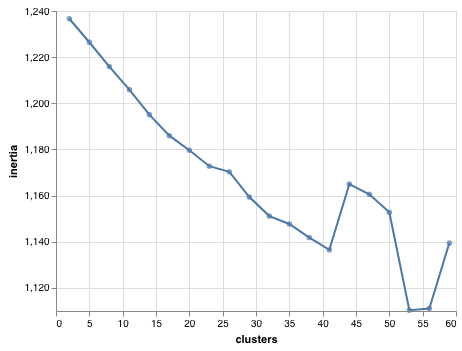

In [14]:
# Again see if there's an obvious knee in the plot
data = alt.Data(values=performance)

lines = alt.Chart(data).mark_line().encode(
    alt.X('clusters:Q', scale=alt.Scale(zero=False)),
    alt.Y('inertia:Q', scale=alt.Scale(zero=False))
)

points = alt.Chart(data).mark_circle().encode(
    alt.X('clusters:Q', scale=alt.Scale(zero=False)),
    alt.Y('inertia:Q', scale=alt.Scale(zero=False))
)

lines + points

#### Abandon this line of pursuit
Don't want a zillion clusters. This is not the way to go.

In [15]:
# Agglomerative (not much better than KMeans)
from sklearn.cluster import AgglomerativeClustering

cluster_maker = AgglomerativeClustering(n_clusters=10)
cluster_maker.fit(dataset)
Counter(cluster_maker.labels_)


Counter({1: 1129, 0: 89, 7: 1, 8: 1, 6: 1, 2: 2, 5: 1, 9: 1, 3: 31, 4: 16})

In [16]:
cluster_maker.fit(tfidf_dataset.toarray())
Counter(cluster_maker.labels_)

Counter({1: 1093,
         0: 58,
         5: 10,
         7: 8,
         6: 21,
         3: 16,
         8: 29,
         2: 14,
         9: 11,
         4: 12})

#### Look at the different clusters and see what's in them

The TFIDF array is still awful, but less. Look at some of the titles in the clusters.

In [17]:
# Change this for different clusters
cluster_label = 5


counter = 1
ordered_titles = [title for title in talks]
colnames = vec.get_feature_names()

for i, lab in enumerate(cluster_maker.labels_):
    if lab == cluster_label:
        print('{} ({:0.0f})\n'.format(ordered_titles[i], sum(dataset[i])), end='\t')
        for j, indicator in enumerate(tfidf_dataset.toarray()[i]):
            if indicator > 0:
                print(colnames[j], end=', ')
        print()
        counter += 1
    if counter > 10:
        break

MONDO : A Shared Library and Dynamic Linking Monitor (3)
	dynamic, library, scripting languages, 
vobject - An iCalendar Library (2)
	library, recent years, 
soaplib: an easy-to-use python soap library (1)
	library, 
Buffer interface in Py3K (2)
	data types, interface, 
New *and* Improved: Coming changes to unittest, the standard library test framework (8)
	framework, library, new, several years, standard, standard library, test, testing framework, 
What's new and interesting in standard library (7)
	's new, library, new, new features, new interesting, standard, standard library, 
Diff It To Dig It (1)
	data types, 
CuPy: A NumPy-compatible Library for GPU (2)
	data types, library, 
HTTP in Python: which library for what task? (4)
	'll cover, library, new implementation, works well, 
Hidden Treasures in the Standard Library (3)
	library, standard, standard library, 


### Try Latent Dirichlet Analysis

Because it's actually designed to infer topics from text corpora. Why wasn't this the first choice?

In [18]:
# Latent Dirichlet
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(20, learning_method='batch')
result = lda.fit_transform(dataset)

def count_group(index, threshold=0.6):
    return sum(1 if row[index] > threshold else 0 for row in result)


print(", ".join("{}-{}".format(i, count_group(i)) for i in range(result.shape[1])))

0-48, 1-68, 2-53, 3-56, 4-52, 5-63, 6-49, 7-61, 8-49, 9-49, 10-68, 11-46, 12-44, 13-42, 14-42, 15-57, 16-51, 17-50, 18-62, 19-56


Cool! The counts are not, like 1000, 10, 1, 1, 1 anymore. With LDA there's a much better distribution of talks among categories, but check to see whether the titles in a group make any sense by looking at titles in a given group:

In [19]:
# And look at the titles in a given group
def show_group(index, threshold=0.6):
    for i,row in enumerate(result):
        if row[index] > threshold:
            print(ordered_titles[i])

group_number = 17
show_group(group_number, threshold=.9)

The Star Schema in Python - Analysis and Reporting without Overheads
Developing Flask Extensions
Games for Science: Creating interactive psychology experiments in Python with Panda3D
REST is not enough: Using Push Notifications to better support your mobile clients
In Depth PDB
2D/3D graphics with Python on mobile platforms
Finding Your Groove: Contributing to CPython and Beyond
A tale of concurrency through creativity in Python:В a deep dive into how gevent works.
Next Level Testing
The Next Step: Finding Model Parameters With Random Walks
aiosmtpd - A better asyncio based SMTP server
Debugging PySpark -- Or trying to make sense of a JVM stack trace when you were minding your own bus
Beyond Passwords: Secure Authentication with Mozilla Persona
API Design anti-patterns
Why is Python slow and how PyPy can help?


#### Actually some insight

So one of the topics looks like concurrency (Twisted | tornado | parallel), one looks like teaching, one looks like deployment (packaging | zc.buildout | stand-alone apps | porting).

But a lot of these aren't close to each other in my mind. What is causing them to cluster?

In [20]:
# This is from the example
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([colnames[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda, 5)

Topic #0: write programming jython 10 minutes server side
Topic #1: making app api take advantage case study
Topic #2: `` '' 's new last year testing web applications
Topic #3: web framework django web development development web sites
Topic #4: interpreter lock global interpreter better software development 'll explore
Topic #5: brief overview world let 's real world `` ''
Topic #6: systems lessons learned continuous integration taking advantage get
Topic #7: learning machine learning building system introduction
Topic #8: beyond 'll cover library project jython
Topic #9: user group along way testing user interface local user
Topic #10: 'll show standard library error handling introduction twisted
Topic #11: programming languages django patterns programming language best practices
Topic #12: natural language language processing language natural web application
Topic #13: data structures data structure structures performance high school
Topic #14: development web frameworks 'll show op

## Step three

Use a manually curated set of tokens. The final categories actually took a couple of weeks of curation and thinking, and still cover no more than maybe a half to two thirds of all talks.

In [21]:
# Two levels: main topic and subtopic in `categories` dictionary
manual_categories = get.categories()

# Flattened to one level
columns = [w for topic,words in manual_categories.items() for w in sorted(words)]

# Indexed so you can find the column number
column_lookup = {c:i for i,c in enumerate(columns)}

In [22]:
all_talks_wordset = {}  # d[conference][title][category] = {'word':1, 'other_word':1}
by_conf_and_cat = {}  # d[conference][category][word] = [list_of_actual_talk_objects]
by_conf_and_cat_counts = {}  # d[conference][category][word] = count


for talk in get.talks():
    conference = '{}-{}'.format(talk.conference.name, talk.conference.year)
    abstract = '' if talk.abstract is None else talk.abstract.lower()
    if conference not in by_conf_and_cat:
        all_talks_wordset[conference] = {}
        by_conf_and_cat[conference] = {k:{} for k in manual_categories}
        by_conf_and_cat_counts[conference] = {k:{'n_talks': 0} for k in manual_categories}
    all_talks_wordset[conference][talk.title] = {}
    for cat, words in manual_categories.items():
        already_counted = False
        for word in words:
            if word in abstract or word in talk.title.lower():
                if cat not in all_talks_wordset[conference][talk.title]:
                    all_talks_wordset[conference][talk.title][cat] = dict([(word, 1)])
                else:
                    all_talks_wordset[conference][talk.title][cat][word] = 1
                if word not in by_conf_and_cat[conference][cat]:
                    by_conf_and_cat[conference][cat][word] = [talk]
                    by_conf_and_cat_counts[conference][cat][word] = 1
                    if not already_counted:
                        by_conf_and_cat_counts[conference][cat]['n_talks'] += 1
                        already_counted = True
                else:
                    by_conf_and_cat[conference][cat][word].append(talk)
                    by_conf_and_cat_counts[conference][cat][word] += 1
                    if not already_counted:
                        by_conf_and_cat_counts[conference][cat]['n_talks'] += 1
                        already_counted = True

In [23]:
### Fix the cats
for conf, d in by_conf_and_cat_counts.items():
    get.categories_fixed(d)

In [24]:
for conf in sorted(by_conf_and_cat_counts):
    categories = by_conf_and_cat_counts[conf]
    identified_talks = len(set(talk for cat,words in by_conf_and_cat[conf].items() for w, talks in words.items() for talk in talks))
    n_talks = get.talk_counts(int(conf[-4:]))
    print('\n{}********{}/{}'.format(conf, identified_talks, n_talks))
    for cat, words in categories.items():
        if cat not in by_conf_and_cat_counts[conf]:
            continue
        n_talks_by_cat = by_conf_and_cat_counts[conf][cat]['n_talks']
        if n_talks_by_cat == 0:
            continue
        print(' --{}----- {} ({}%)'.format(cat, n_talks_by_cat, round(100*n_talks_by_cat/n_talks)))
        print(' ' + ','.join(' {}: {}'.format(word, ct, round(100*ct/n_talks)) for word, ct in words.items() if word != 'n_talks'))


pycon-us-2003********36/41
 --education----- 2 (5%)
  curriculum: 1, school: 1, student: 2, education: 1
 --concurrency----- 8 (20%)
  callback: 1, asynchronous: 1, Twisted: 8
 --performance----- 9 (22%)
  wrapper: 1, performance: 3, memory: 2, thread: 2, bottleneck: 1, efficiency: 2, RAM: 1, CPU: 1
 --advice----- 4 (10%)
  lessons learned: 1, advantages: 1, compare: 1, case study: 1
 --collaboration----- 3 (7%)
  rapid: 2, collaboration: 1, problem solving: 1
 --documentation----- 1 (2%)
  documentation: 1
 --machine learning----- 1 (2%)
  regression: 1
 --numarray----- 1 (2%)
  numarray: 1
 --NumPy----- 1 (2%)
  numpy: 1
 --visualization----- 2 (5%)
  plot: 2
 --image----- 4 (10%)
  graphic: 4
 --application----- 3 (7%)
  user interface: 3
 --database----- 5 (12%)
  database: 4, sql: 1
 --web----- 5 (12%)
  Zope: 4, web development: 3
 --net----- 11 (27%)
  network: 9, Twisted: 8
 --continuous deployment----- 1 (2%)
  deploy: 1
 --workflow----- 2 (5%)
   trac: 2
 --scaling data pipe

#### Correlation matrices

You have to make the font small and this screen wide to avoid word wrapping. Sorry.

Each talk is counted in every category it contains. So the diagonal shows the number of total talks with a given term, and the off-diagonal values show the additional categories the talks showed up in. Some topics, like testing or performance optimization, you can see are in almost every other category (the vertical/horizontal stripe in the correlation matrix).

This is what eventually led to the decision to bite the bullet and manually classify the talks. The manual classification took about a week and a half, as long as the iterative machine learning analyses took. The machine learning was helpful in identifying common terms (e.g. "best practice" and even "software development") that made it into top-level categories.

In [25]:
partial_categories = dict.copy(manual_categories)
for delete in ('GIS', 'IDEs', 'image', 'other', 'workflow'):
    del partial_categories[delete]
sorted_categories = sorted(partial_categories)
#arules = Counter()
coarse = {}
for con, talks in all_talks_wordset.items():
    coarse[con] = [[0]*len(sorted_categories) for c in partial_categories]
    for topics in talks.values():
        #arules.update(all_tuples(topics))
        for i,ci in enumerate(sorted_categories):
            if ci in topics:
                for j,cj in enumerate(sorted_categories):
                    if cj in topics:
                        coarse[con][i][j] += 1


for con in sorted(coarse):
    mat = coarse[con]
    print('\n{}---{} talks'.format(con, len(all_talks_wordset[con])))
    for col, row in zip(sorted_categories, mat):
        print(' '.join('{:<2}'.format(i) if i > 15 else ' #' if i > 10 else ' +' if i > 5 else ' .' if i > 1  else '  ' for i in row) + '  {}'.format(col))



pycon-us-2003---41 talks
                                                                                              IPython/Jupyter
                                                                                              NOSQL
                                                                                              NumPy
                                                                                              Pandas
                                                                                              acquisition
                .                                                                             advice
                   .                                                                          application
                                                                                              cloud
                         .                                   .                                collaboration
                            +        .    

### Thank you!

Thank you for reading this far. I hope it was useful.